**Fruit Object Detection using Deep Learning**

**IMPORT LIBRARIES**

In [2]:
! pip install ultralytics

In [3]:
import cv2
import glob
import shutil
import random
import albumentations as A
import torch
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,average_precision_score
from google.colab.patches import cv2_imshow
from PIL import Image
import os
from ultralytics import YOLO
import xml.etree.ElementTree as ET


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Data Collection**

In [4]:
train_images_path="/content/drive/MyDrive/FruitObject_detection/Train"
test_images_path="/content/drive/MyDrive/FruitObject_detection/Test"

In [5]:
import os

base = "/content/yolo_FruitObject_detection"

for p in [
    "images/train", "images/test", "images/valid",
    "labels/train", "labels/test", "labels/valid"
]:
    os.makedirs(os.path.join(base, p), exist_ok=True)

print("Folders created")


Folders created


**Data Annotation:**
XML TO YOLO CONVERSION FUNCTION

In [6]:
import xml.etree.ElementTree as ET

def convert_xml_to_yolo(xml_path, w, h):
    root = ET.parse(xml_path).getroot()
    classes = {"apple":0, "banana":1, "orange":2}
    yolo = []

    for obj in root.findall("object"):
        cls = classes[obj.find("name").text]

        xmin = int(obj.find("bndbox/xmin").text)
        ymin = int(obj.find("bndbox/ymin").text)
        xmax = int(obj.find("bndbox/xmax").text)
        ymax = int(obj.find("bndbox/ymax").text)

        yolo.append(
            f"{cls} "
            f"{(xmin+xmax)/2/w} "
            f"{(ymin+ymax)/2/h} "
            f"{(xmax-xmin)/w} "
            f"{(ymax-ymin)/h}"
        )

    return yolo

**SPLIT DATASET**

In [7]:
# Load images
train_all = glob.glob("/content/drive/MyDrive/FruitObject_detection/Train/*.jpg")
test_images = glob.glob("/content/drive/MyDrive/FruitObject_detection/Test/*.jpg")

# Shuffle
random.shuffle(train_all)

# 80-20 split
split = int(0.8 * len(train_all))
train_images = train_all[:split]
valid_images = train_all[split:]

# Print counts
print(len(train_images), "train")
print(len(valid_images), "valid")
print(len(test_images), "test")


192 train
48 valid
60 test


**Data Annotation: CONVERT AND COPY IMAGES TO YOLO FORMAT**
# Annotate images with bounding boxes for each fruit using tools like LabelImg or Roboflow to generate YOLO-format or Pascal VOC XML annotations.

In [8]:
def process_split(image_list, mode):
    for image_path in image_list:
        img = cv2.imread(image_path)
        if img is None:
            continue

        h, w = img.shape[:2]

        # Correct XML path handling
        xml_path = os.path.splitext(image_path)[0] + ".xml"
        if not os.path.exists(xml_path):
            continue

        yolo_labels = convert_xml_to_yolo(xml_path, w, h)

        # Create folders safely (train / test / valid)
        os.makedirs(os.path.join(images_folder, mode), exist_ok=True)
        os.makedirs(os.path.join(labels_folder, mode), exist_ok=True)

        # Copy image
        shutil.copy(
            image_path,
            os.path.join(images_folder, mode, os.path.basename(image_path))
        )

        # Write label file
        label_path = os.path.join(
            labels_folder,
            mode,
            os.path.splitext(os.path.basename(image_path))[0] + ".txt"
        )

        with open(label_path, "w") as f:
            f.write("\n".join(yolo_labels))


## **Data Preprocessing:DATA AUGMENTATION**

In [9]:

import os
import cv2

base = "/content/yolo_FruitObject_detection"

images_folder = os.path.join(base, "images")
labels_folder = os.path.join(base, "labels")

# augmented folders (same level as train)
os.makedirs(os.path.join(images_folder, "train_aug"), exist_ok=True)
os.makedirs(os.path.join(labels_folder, "train_aug"), exist_ok=True)


def save_augmented(image, bboxes, class_labels, img_name):
    # image path
    img_out_path = os.path.join(images_folder, "train_aug", img_name)

    # label path
    label_out_path = os.path.join(
        labels_folder,
        "train_aug",
        os.path.splitext(img_name)[0] + ".txt"
    )

    # save image
    cv2.imwrite(img_out_path, image)

    # save labels
    with open(label_out_path, "w") as f:
        for bbox, cls in zip(bboxes, class_labels):
            f.write(f"{cls} {' '.join(map(str, bbox))}\n")


In [10]:
import os, glob, cv2

base = "/content/yolo_FruitObject_detection"
images_folder = os.path.join(base, "images")
labels_folder = os.path.join(base, "labels")

img_paths = glob.glob(os.path.join(images_folder, "train", "*.jpg"))

for img_path in img_paths:
    name = os.path.basename(img_path)

    txt_path = os.path.join(
        labels_folder, "train",
        name.replace(".jpg", ".txt")
    )

    if not os.path.exists(txt_path):
        continue

    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    bboxes, labels = [], []
    with open(txt_path) as f:
        for line in f:
            c, x, y, w, h = map(float, line.split())
            labels.append(int(c))
            bboxes.append([x, y, w, h])

    out = transform(image=img, bboxes=bboxes, class_labels=labels)

    cv2.imwrite(
        os.path.join(images_folder, "train_aug", name),
        cv2.cvtColor(out["image"], cv2.COLOR_RGB2BGR)
    )

    with open(
        os.path.join(labels_folder, "train_aug", name.replace(".jpg", ".txt")),
        "w"
    ) as f:
        for c, (x, y, w, h) in zip(out["class_labels"], out["bboxes"]):
            f.write(f"{c} {x} {y} {w} {h}\n")


In [11]:
import os, glob, cv2

images_folder = "/content/yolo_FruitObject_detection/images"
labels_folder = "/content/yolo_FruitObject_detection/labels"

os.makedirs(images_folder + "/train_aug", exist_ok=True)
os.makedirs(labels_folder + "/train_aug", exist_ok=True)

# collect banana images (class 1)
banana_imgs = []
for img in glob.glob(images_folder + "/train/*.jpg"):
    txt = img.replace("images", "labels").replace(".jpg", ".txt")
    if not os.path.exists(txt):
        continue

    with open(txt) as f:
        for line in f:
            if int(line.split()[0]) == 1:
                banana_imgs.append(img)
                break

# augment
for img in banana_imgs:
    txt = img.replace("images", "labels").replace(".jpg", ".txt")
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)


In [12]:
device="cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


**CREATE DATA YAML**

In [13]:
data_yaml = """
train:
  - /content/yolo_FruitObject_detection/images/train
  - /content/yolo_FruitObject_detection/images/train_aug

val: /content/yolo_FruitObject_detection/images/valid

nc: 3
names:
  - apple
  - banana
  - orange
"""

with open("/content/yolo_FruitObject_detection/data.yaml", "w") as f:
    f.write(data_yaml)


In [14]:
!ls /content/yolo_FruitObject_detection/images/train | head
!ls /content/yolo_FruitObject_detection/images/train_aug | head
!ls /content/yolo_FruitObject_detection/labels/train | head


**Model Training :TRAIN YOLOV8**

In [15]:
process_split(train_images, "train")
process_split(valid_images, "valid")
process_split(test_images, "test")


In [16]:
import os

for folder in [images_folder + "/train", images_folder + "/valid", images_folder + "/train_aug"]:
    print(folder, ":", len([f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png'))]), "images")


/content/yolo_FruitObject_detection/images/train : 192 images
/content/yolo_FruitObject_detection/images/valid : 48 images
/content/yolo_FruitObject_detection/images/train_aug : 0 images


In [17]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")

model.train(
    data="/content/yolo_FruitObject_detection/data.yaml",
    epochs=50,
    batch=8,
    imgsz=640,
    device=device,
    patience=10
)


Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_FruitObject_detection/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7d3f2d4c3140>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

***EVALUATE MODEL***

In [18]:
metrics=model.val()
print(metrics)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1270.5±1022.4 MB/s, size: 57.8 KB)
val: Scanning /content/yolo_FruitObject_detection/labels/valid.cache... 48 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 48/48 111.8Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 3/3 1.4it/s 2.1s
                   all         48         91      0.903      0.849       0.91      0.666
                 apple         20         28      0.913          1      0.995      0.799
                banana         23         40      0.845      0.546      0.743      0.447
                orange         18         23       0.95          1      0.993      0.753
Speed: 5.2ms preprocess, 12.8ms inference, 0.0ms loss, 4.5ms postprocess per image
Results saved to /content/runs/detect/v

In [19]:
summary=metrics.summary()
print(summary)

[{'Class': 'apple', 'Images': np.int64(20), 'Instances': np.int64(28), 'Box-P': np.float64(0.91304), 'Box-R': np.float64(1.0), 'Box-F1': np.float64(0.95454), 'mAP50': np.float64(0.995), 'mAP50-95': np.float64(0.79904)}, {'Class': 'banana', 'Images': np.int64(23), 'Instances': np.int64(40), 'Box-P': np.float64(0.84516), 'Box-R': np.float64(0.54594), 'Box-F1': np.float64(0.66337), 'mAP50': np.float64(0.74302), 'mAP50-95': np.float64(0.44668)}, {'Class': 'orange', 'Images': np.int64(18), 'Instances': np.int64(23), 'Box-P': np.float64(0.95049), 'Box-R': np.float64(1.0), 'Box-F1': np.float64(0.97462), 'mAP50': np.float64(0.99333), 'mAP50-95': np.float64(0.75291)}]


In [20]:
metrics.confusion_matrix.matrix

array([[         28,           0,           3,           4],
       [          0,          26,           0,          11],
       [          0,           0,          20,           4],
       [          0,          14,           0,           0]])

**# CUSTOM EVALUATION AND CALCULATE METRICS**

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score
import numpy as np

def eval_custom(y_true, y_scores):
    # Compute metrics
    auc_roc = roc_auc_score(y_true, y_scores)
    auc_pr  = average_precision_score(y_true, y_scores)
    y_pred  = (np.array(y_scores) > 0.5).astype(int)
    f1      = f1_score(y_true, y_pred)
    return auc_roc, auc_pr, f1

# Example usage
y_true = [0, 1, 1, 0, 1]
y_scores = [0.1, 0.9, 0.75, 0.2, 0.8]

metrics = eval_custom(y_true, y_scores)
print(metrics)


(np.float64(1.0), np.float64(1.0), 1.0)


**# PREDICTION ON TEST IMAGE**


0: 480x640 1 apple, 5 oranges, 13.1ms
Speed: 4.3ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


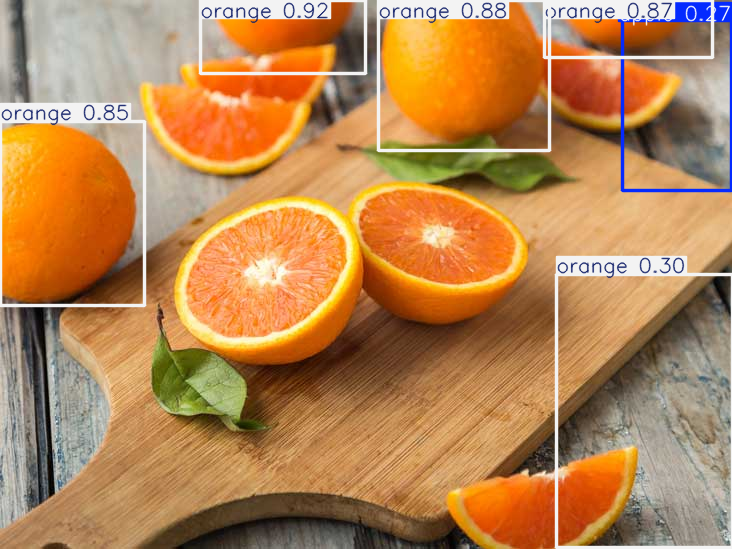

In [23]:
img=cv2.imread(test_images[1])
results=model(img)
out=results[0].plot()

cv2_imshow(out)